In [73]:
# --- Auto-reload packages when code changes (no kernel restart needed) ---
try:
    # For Jupyter/IPython environments
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
    print("🔄 Autoreload enabled: code changes will be auto-reloaded!")
except Exception as e:
    print("⚠️ Could not enable autoreload (not in IPython/Jupyter?):", e)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
🔄 Autoreload enabled: code changes will be auto-reloaded!


In [74]:
# Clean solution: Auto-add project root to path
import sys
import os
import matplotlib.pyplot as plt

# Get the project root (parent directory of examples/)
project_root = os.path.dirname(os.path.abspath('.'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Now import everything cleanly
from DynaSD import GIN, NDD, LiNDDA, MINDA, IMPRINT

import numpy as np
import pandas as pd

from tests.synthetic_data_generator import SyntheticSeizureGenerator

print("✅ DynaSD imported successfully!")
print(f"📁 Project root: {project_root}")
print(f"🐍 Using Python: {sys.executable}")

# Verify the imports work
print(f"📦 GIN class: {GIN}")
print(f"📦 NDD class: {NDD}")


✅ DynaSD imported successfully!
📁 Project root: /Users/wojemann/Documents/CNT/DynaSD
🐍 Using Python: /Users/wojemann/Documents/CNT/DynaSD/dynasd_env/bin/python
📦 GIN class: <class 'DynaSD.GIN.GIN'>
📦 NDD class: <class 'DynaSD.NDD.NDD'>


In [105]:
fs = 256
generator = SyntheticSeizureGenerator(fs=fs, random_seed=42)

data,sz_start,sz_end = generator.generate_combined_signal(baseline_duration=20, seizure_duration=10, seizure_type='spike_wave', n_channels=16, focal_channels=list(range(8)), transition_duration=0)


(<Figure size 999.87x320 with 1 Axes>, <Axes: xlabel='Time (s)'>)

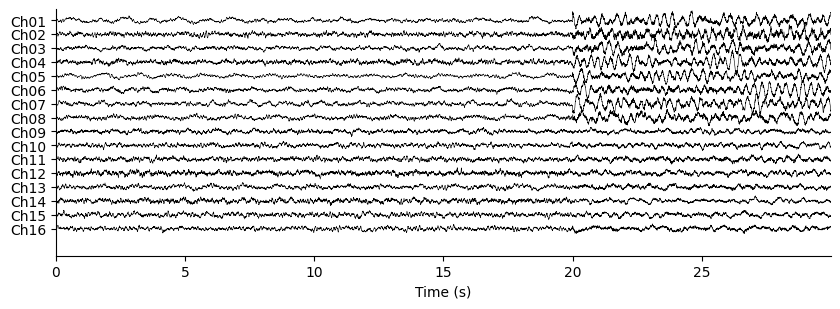

In [106]:
from example_utils import plot_iEEG_data

plot_iEEG_data(data,fs=fs)

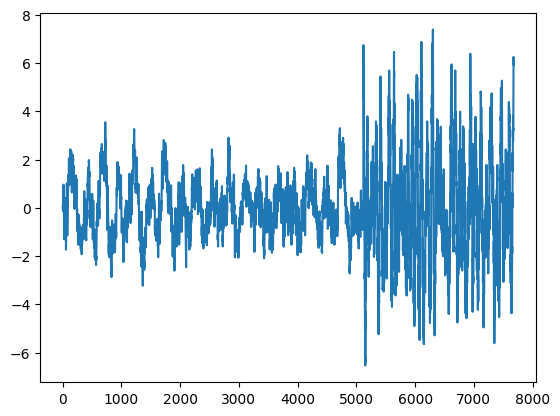

In [107]:
import scipy as sc
plt.plot(data[['Ch01']])
plt.show()

In [108]:
model = IMPRINT(fs=fs,w_stride=0.5,w_size=1)
model.fit(data.iloc[:fs*10,:])

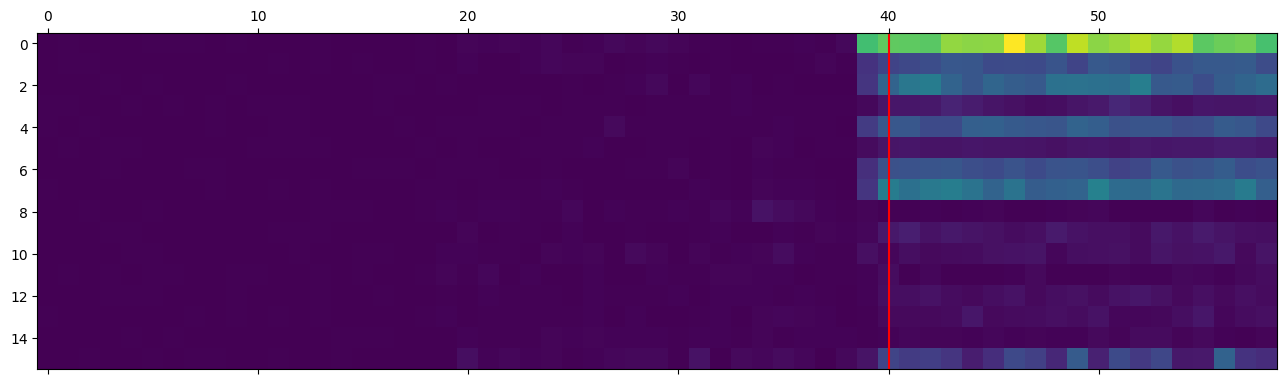

In [109]:
test = model(data)
prob_times = model.get_win_times(len(data))
vline_idx = np.argmin(np.abs(prob_times - sz_start))
plt.matshow(pd.DataFrame(test,columns=data.columns).T)
plt.axvline(x=vline_idx,color='r')
plt.show()

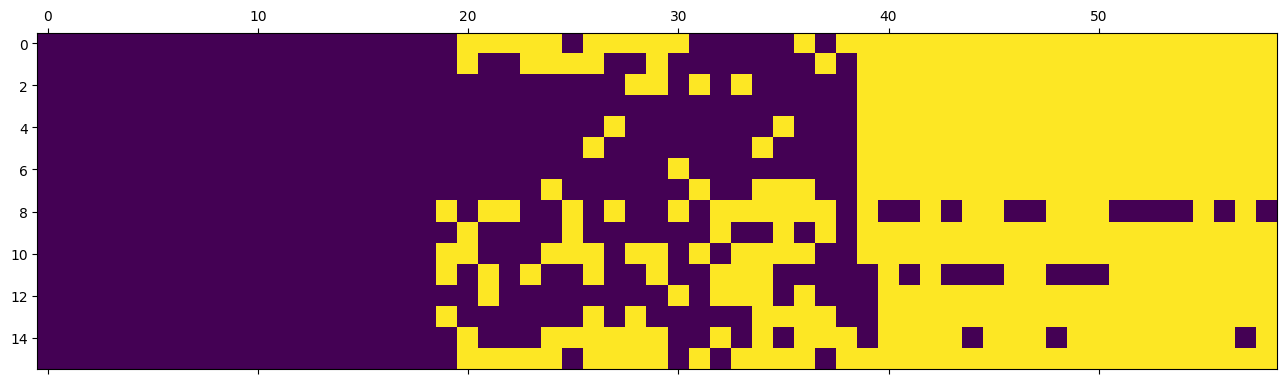

In [110]:
plt.matshow(test.T > model.mad_thresh)

In [145]:
# model = GIN(num_epochs=100,batch_size=32,lambda_zcr=0,sequence_length = 64,
# hidden_size=256,early_stopping=True, num_layers=4,lr=0.0005,w_stride=0.125,w_size=1)
model = LiNDDA(num_epochs=200,batch_size=32,lambda_zcr=0,sequence_length = 32,early_stopping=True,lr=0.0005,w_stride=0.5,w_size=1)
# model = MINDA(num_epochs=100,batch_size=32,lambda_zcr=0,
# sequence_length = 8,early_stopping=True,lr=0.0005,dropout=0.0,hidden_sizes=[128,512,64],w_stride=0.125,w_size=2)
model.fit(data.iloc[:fs*10,:])

  Model: LinearForecaster_16ch_32seq
  Parameters: 262,656
Training LinearForecaster model:
  Sequence length: 32 (input=forecast)
  Early stopping: True
Creating 79 non-overlapping sequences from continuous data
  Created 79 sequences
  Training sequences: 64, Validation sequences: 15
Starting training...


Training:   7%|▋         | 14/200 [00:00<00:07, 25.27it/s, train_loss=0.2684, val_loss=0.5768, patience=5]



Early stopping triggered after 15 epochs
Training completed


Creating 239 non-overlapping sequences from continuous data


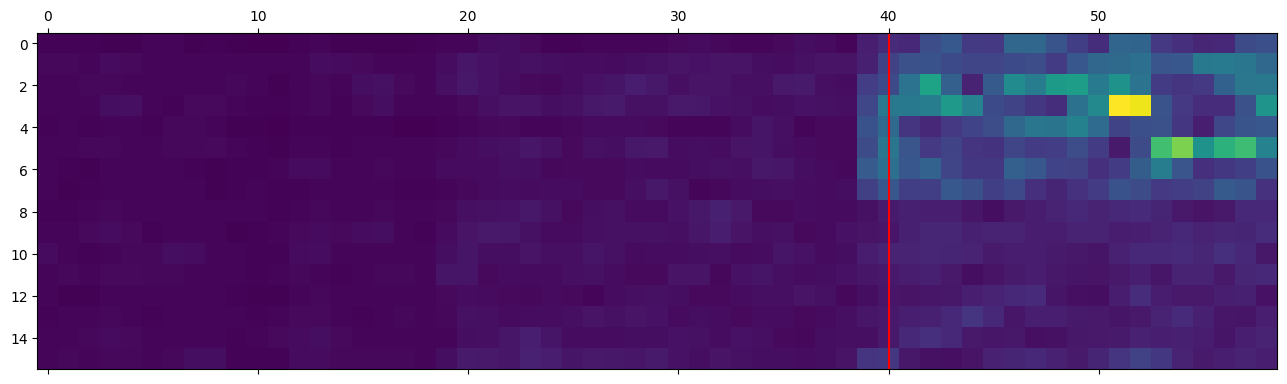

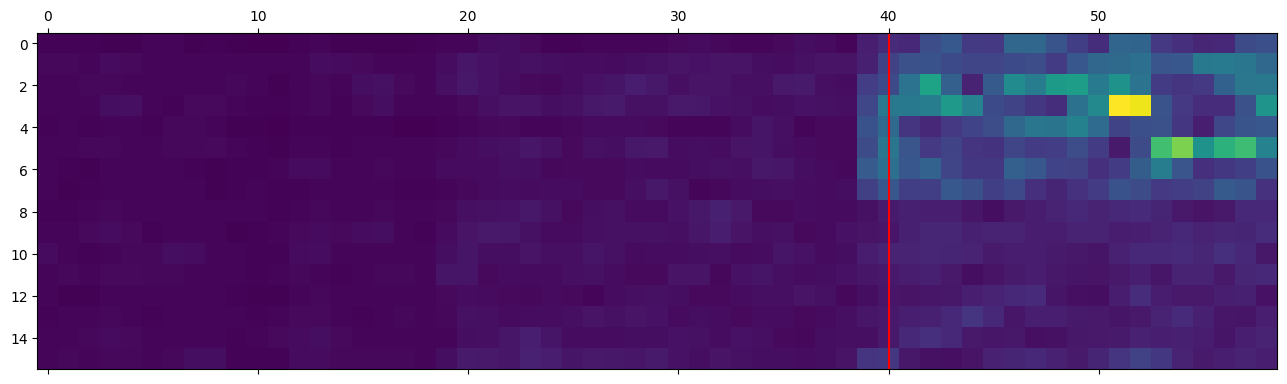

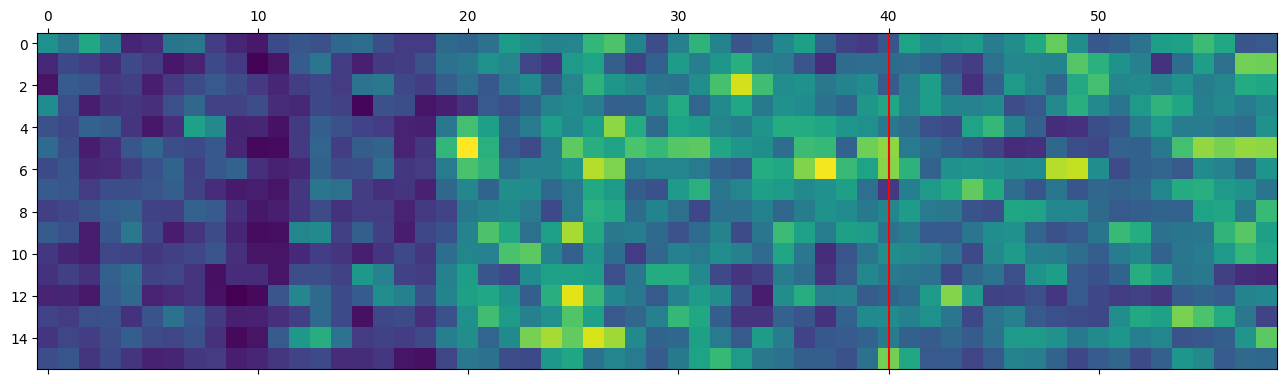

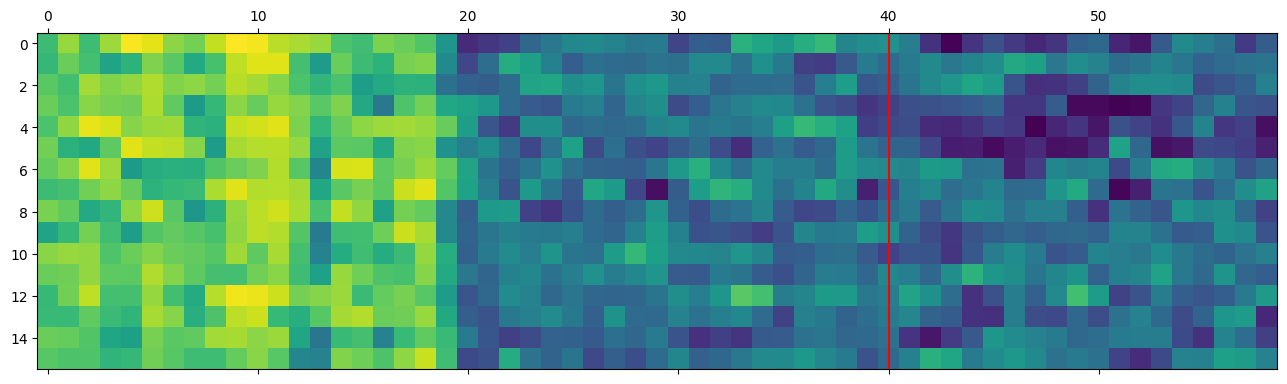

Creating 239 non-overlapping sequences from continuous data


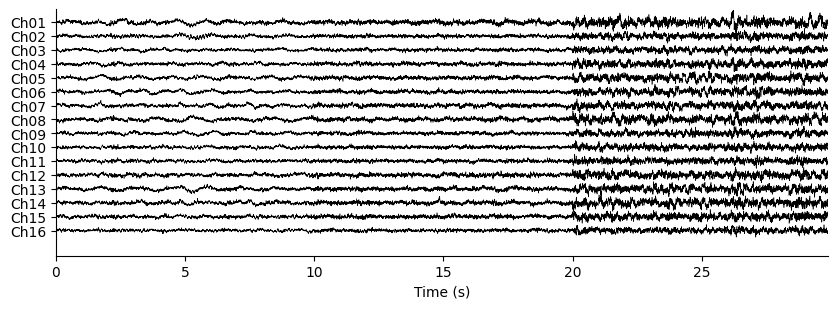

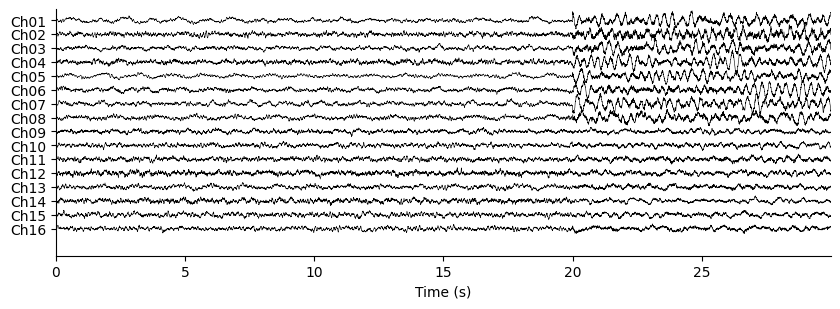

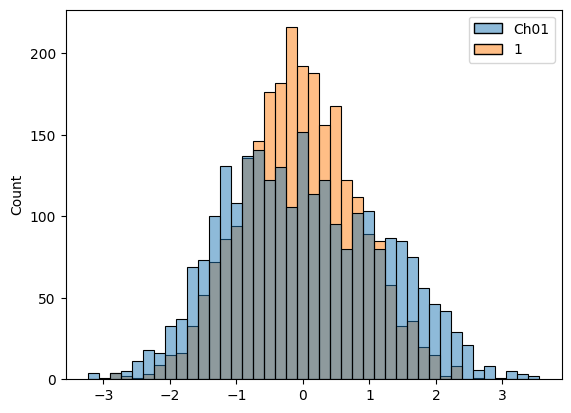

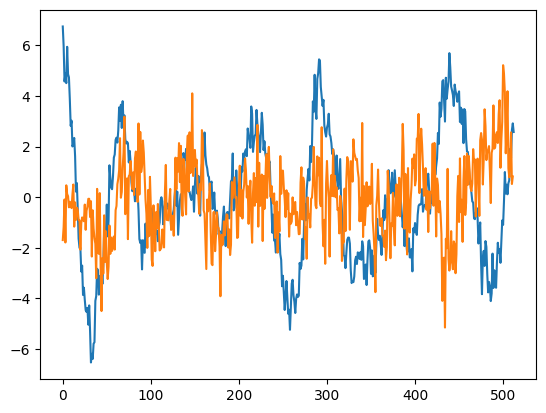

In [146]:
mse,zcr,total,corr = model(data)
g_times = model.get_win_times(len(data))
onset_idx = np.argmin(np.abs(g_times-sz_start))
for mat in [total,mse,zcr,corr]:
    plt.matshow(mat.T)
    # plt.colorbar()
    plt.axvline(x=onset_idx,color='r')
    plt.show()
x = model.predict(data)
plot_iEEG_data(pd.DataFrame(x,columns=data.columns).loc[np.isnan(x).sum(axis=1)==0,:],fs=fs)
plot_iEEG_data(data,fs=fs)
plt.show()
import seaborn as sns
sns.histplot((data['Ch01'][:fs*10],x[:fs*10,0]))
plt.show()
s = 20*fs
plt.plot(data.loc[s:s+512,['Ch01']].values)
plt.plot(x[s:s+512,0])

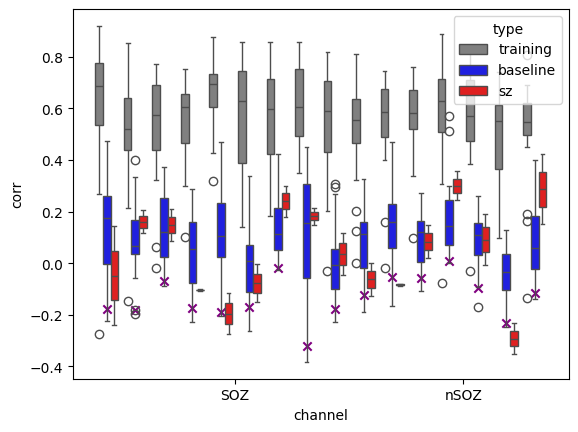

In [147]:
train_mask = (g_times <= 10)
train_df = pd.DataFrame(corr[train_mask],columns=data.columns)
gen_mask = (g_times <= sz_start) & (g_times > 10)
gen_df = pd.DataFrame(corr[gen_mask],columns=data.columns)
sz_mask = (g_times <= sz_start+1) & (g_times > sz_start)
sz_df = pd.DataFrame(corr[sz_mask],columns=data.columns)
train_df['type'] = 'training'
gen_df['type'] = 'baseline'
sz_df['type'] = 'sz'
df = pd.concat([train_df,gen_df,sz_df])
df = df.melt(id_vars=['type'],var_name='channel',value_name='corr')
sns.boxplot(data=df,x='channel',y='corr',hue='type',palette=['gray','blue','red'])
plt.scatter(list(range(gen_df.shape[1]-1)), gen_df.iloc[:,:-1].quantile(0.05),color='purple',marker='x')
plt.xticks([4.5,12.5],['SOZ','nSOZ'])
plt.show()

In [148]:
from sklearn.mixture import GaussianMixture
corr = -1*corr.iloc[100:,:]
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(corr.values.reshape(-1,1))

import numpy as np

# Plot the histogram of the data
sns.histplot(corr.values.flatten(), bins=50, stat='density', color='skyblue', label='Data', alpha=0.6)

# Plot the estimated Gaussian components
x = np.linspace(corr.values.min(), corr.values.max(), 1000).reshape(-1, 1)
logprob = gmm.score_samples(x)  # Score for each x, repeated for 8 channels
pdf = np.exp(logprob)
plt.plot(x, pdf, color='black', lw=2, label='GMM mixture')

# Plot each component
means = gmm.means_.flatten()
covars = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_.flatten()
for mean, covar, weight in zip(means, covars, weights):
    component_pdf = weight * (1/(np.sqrt(2*np.pi)*covar)) * np.exp(-0.5*((x-mean)/covar)**2)
    plt.plot(x, component_pdf, lw=2, linestyle='--', label=f'Component μ={mean:.2f}')

plt.legend()
plt.xlabel('corr')
plt.ylabel('Density')
plt.title('Distribution of corr and GMM fit')
plt.show()


ValueError: Found array with 0 sample(s) (shape=(0, 1)) while a minimum of 2 is required by GaussianMixture.

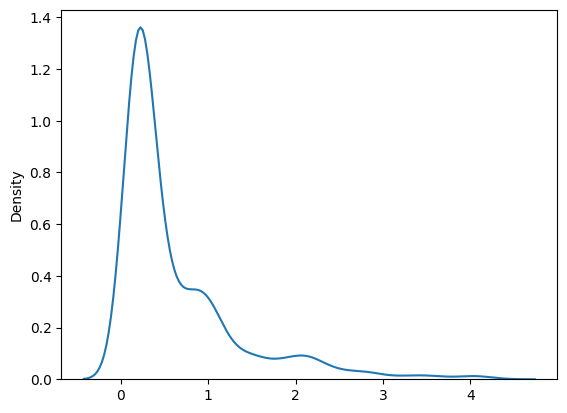

In [115]:
sns.kdeplot(-1*corr.iloc[:,:8].values.flatten())
plt.show()